In [1]:
from keras.datasets import boston_housing
import keras
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 2us/step


In [2]:
train_data.shape , test_data.shape


((404, 13), (102, 13))

### Feature Informations 

As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as follow:

* Per capita crime rate.
* Proportion of residential land zoned for lots over 25,000 square feet.
* Proportion of non-retail business acres per town.
* Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
* Nitric oxides concentration (parts per 10 million).
* Average number of rooms per dwelling.
* Proportion of owner-occupied units built prior to 1940.
* Weighted distances to five Boston employment centres.
* Index of accessibility to radial highways.
* Full-value property-tax rate per $10,000.
* Pupil-teacher ratio by town.
* 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
* % lower status of the population.

Price Range for the targets is between  5K $ to  50K $

In [8]:
max(train_targets) , min(train_targets)

(50.0, 5.0)

In [9]:
mean = train_data.mean(axis=0)
train_data -= mean  # Does the mean Normilization 
std = train_data.std(axis=0) # Doing the STD normalization 
train_data /= std


# Doing the same thing on the test data set
test_data -= mean # 
test_data /= std

#### Bulding my Nice Neural Network  
* The shape of the neural network would be the shape of the first record found 

In [11]:
train_data.shape[1] # 13 1 dimentional columns

13

In [13]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],))) # Using the shape for the training data t
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) # Mean Squared error for the loss 
    # Mean Absolute error as a metics
    return model

Our network ends with a single unit, and no activation (i.e. it will be linear layer). This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). Applying an activation function would constrain the range that the output can take; for instance if we applied a sigmoid activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the mse loss function -- Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: mae. This stands for Mean Absolute Error. It is simply the absolute value of the difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by \$500 on average.

#### Validation the approach by using cross validation as K fold 

In [14]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### Scores for the model at different K variations 

In [15]:
np.mean(all_scores)

2.498778820037842

In [21]:
from keras import backend as K

# Some memory clean-up
K.clear_session()
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    # partial Targets
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    #print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [23]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] # Average per history 

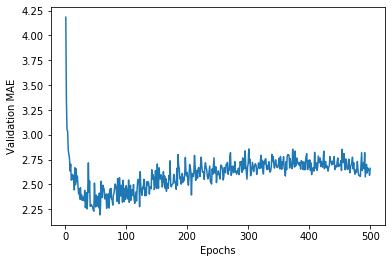

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

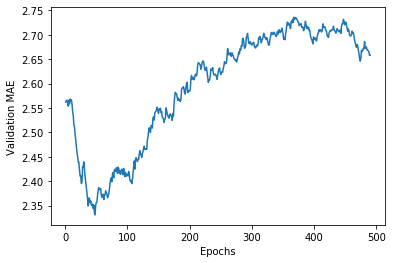

In [26]:
def smooth_curve(points, factor=0.9):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Wrapping up¶
Here's what you should take away from this example:

* Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
* When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.


This example concludes our series of three introductory practical examples. You are now able to handle common types of problems with vector data input:

* Binary (2-class) classification.
* Multi-class, single-label classification.
* Scalar regression.
In the next chapter, you will acquire a more formal understanding of some of the concepts you have encountered in these first examples, such as data preprocessing, model evaluation, and overfitting.